In [1]:
from IPython.display import display
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import pandas as pd


#field parameters
field_rows, field_cols = 9, 7
start_row, start_col = 4, 3

# Parameters for cropping and cell splitting
crop_coordinates = (126, 402, 996, 1554)  # Adjust if needed
screenshots_directory = "Screenshots"

rows, cols = 9, 7  # Grid size for splitting image into cells
square_size = 16  # Sample square size within each cell
margins = (5, 5, 5, 5)  # Margins for the sample square
shift_pct = 0.22  # Upward shift percentage for the sample square
# Defined color for each prize category
known_categories = {
    0: np.array([234, 223, 223]),  # 0 score
    1: np.array([155, 209, 203]),  # 1 score
    2: np.array([222, 165, 224]),  # 2 score
    3: np.array([230, 160, 154])   # 3 score
}

def load_and_crop_screenshot(directory, filename, crop_coordinates):
    """Loads a specified screenshot from the directory, crops it, and returns the cropped image."""
    screenshot_path = os.path.join(directory, filename)
    print("Processing screenshot:", screenshot_path)
    
    img = Image.open(screenshot_path)
    if img.mode == 'RGBA':
        img = img.convert('RGB')
    cropped_img = img.crop(crop_coordinates)
    
    return cropped_img

def split_image_into_cells(cropped_img, rows, cols, square_size, margins, shift_pct=0.3):
    """
    Splits the cropped image into individual cells, samples a square from each cell with an upward shift,
    and returns them.

    :param cropped_img: Cropped image of the game field.
    :param rows: Number of rows in the game field.
    :param cols: Number of columns in the game field.
    :param square_size: Size of the square to sample from each cell.
    :param margins: A tuple of (top_margin, right_margin, bottom_margin, left_margin).
    :param shift_pct: Percentage to shift the square upward from the center of the cell.
    """
    width, height = cropped_img.size
    cell_width = width / cols
    cell_height = height / rows
    
    cells = []
    for row in range(rows):
        for col in range(cols):
            center_x = col * cell_width + cell_width / 2
            center_y = row * cell_height + cell_height / 2
            
            # Apply the upward shift
            shift_upward = cell_height * shift_pct
            center_y_shifted = center_y - shift_upward
            
            top_margin, right_margin, bottom_margin, left_margin = margins
            
            left = center_x - square_size / 2 + left_margin
            right = center_x + square_size / 2 - right_margin
            upper = center_y_shifted - square_size / 2 + top_margin
            lower = center_y_shifted + square_size / 2 - bottom_margin
            
            bounding_box = (left, upper, right, lower)
            cell = cropped_img.crop(bounding_box)
            cells.append(cell)
    
    return cells

def measure_cell_color(cell):
    np_cell = np.array(cell)
    avg_color = np.mean(np_cell, axis=(0, 1)).round().astype(int)
    return avg_color

def categorize_cell(cell, categories):
    avg_color = measure_cell_color(cell)
    category_distances = {}
    
    for category, color in categories.items():
        distance = np.linalg.norm(avg_color - color)
        category_distances[category] = round(distance)
    
    closest_category = min(category_distances, key=category_distances.get)
    closest_distance = category_distances[closest_category]
    return closest_category, closest_distance, category_distances

def categorize_and_populate_field(cells, known_categories, rows, cols):
    """
    Categorizes each cell and populates a grid based on the categories.

    :param cells: List of cell images.
    :param known_categories: Dictionary of known categories with their corresponding colors.
    :param rows: Number of rows in the grid.
    :param cols: Number of columns in the grid.
    :return: A 2D list representing the categorized field.
    """
    # Initialize the field variable as a grid of zeros
    field = [[0 for _ in range(cols)] for _ in range(rows)]

    # Categorize each cell and populate the field variable
    for idx, cell in enumerate(cells):
        row = idx // cols  # Determine the cell's row
        col = idx % cols   # Determine the cell's column
        
        category, closest_distance, all_distances = categorize_cell(cell, known_categories)
        
        # Directly use the category as score
        field[row][col] = category

    return field

def debug_analysis(cells, known_categories):
    # Print the total number of cells generated
    print(f"Total cells generated: {len(cells)}")  # This should print 63 for a 9x7 grid

    # Categorize each cell and gather distances
    cells_categories_distances = [categorize_cell(cell, known_categories) for cell in cells]

    # Print categorized cells and distances for analysis
    for idx, (category, closest_distance, all_distances) in enumerate(cells_categories_distances):
        print(f"Cell {idx + 1}: Closest Category = {category}, Closest Distance = {closest_distance}")
        for cat, dist in all_distances.items():
            print(f"    Distance to {cat} score: {dist}")

In [2]:
def visualize_field(field, figsize=(3, 3)):  # Adjusted figsize here
    """Visualizes the game field with customized colors for different cell values."""
    # Define the colors for different cell values
    cmap = ListedColormap(['#EEEEEE', '#4DB6AC', '#9575CD', '#E57373'])
    
    # Define the boundaries for your colormap
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]  # Defines the range for each color
    norm = BoundaryNorm(bounds, cmap.N)
    
    field_array = np.array(field)
    plt.figure(figsize=figsize)  # Use the figsize parameter
    plt.imshow(field_array, cmap=cmap, norm=norm, interpolation='nearest')

    # Add gridlines for better readability
    plt.grid(which='both', color='black', linestyle='-', linewidth=1)
    plt.xticks(np.arange(-0.5, len(field[0]), 1), "")
    plt.yticks(np.arange(-0.5, len(field), 1), "")
    plt.scatter(start_col, start_row, color='blue', s=50)  # s is the size of the point

    # Adjust the tick parameters so that the grid aligns well
    plt.tick_params(
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False
    )

    plt.title('Game Field')
    plt.show()

    
def visualize_field_with_path(field, path, plot_title = 'Unnamed', figsize=(3, 3)):
    """Visualizes the game field with a path line overlaid."""
    # Define the color map for different cell values
    cmap = ListedColormap(['#EEEEEE', '#4DB6AC', '#9575CD', '#E57373'])
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = BoundaryNorm(bounds, cmap.N)

    # Convert the field to a NumPy array for easier plotting
    field_array = np.array(field)
    plt.figure(figsize=figsize)
    plt.imshow(field_array, cmap=cmap, norm=norm, interpolation='nearest')

    # Extract path coordinates based on the new path format
    path_coords = extract_path_coordinates(path)

    # If there are path coordinates, plot the path
    if path_coords:
        y_coords, x_coords = zip(*path_coords)  # Note: plt.plot expects x and y in this order
        plt.plot(x_coords, y_coords, color='blue', linewidth=2, marker=',', markersize=5, markerfacecolor='red')

    # Add gridlines for better readability
    plt.grid(which='both', color='black', linestyle='-', linewidth=1)
    plt.xticks(np.arange(-0.5, len(field[0]), 1), "")
    plt.yticks(np.arange(-0.5, len(field), 1), "")
    plt.scatter(start_col, start_row, color='blue', s=50)  # s is the size of the point
    
    plt.tick_params(
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False
    )

    plt.title(plot_title)
    plt.show()

def extract_path_coordinates(path):
    """Extracts and orders the path coordinates from the path string."""
    path_coords = [(start_row, start_col)]  # Include the starting point
    current_row, current_col = start_row, start_col
    for move in path:
        if move == 'U':
            current_row -= 1
        elif move == 'D':
            current_row += 1
        elif move == 'L':
            current_col -= 1
        elif move == 'R':
            current_col += 1
        path_coords.append((current_row, current_col))
    return path_coords

Processing screenshot: Screenshots\000.png


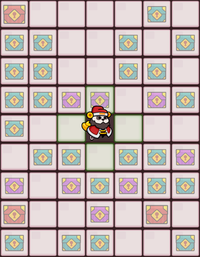

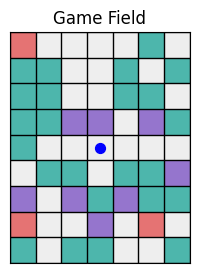

In [3]:
cropped_img = load_and_crop_screenshot(screenshots_directory, "000.png", crop_coordinates)
cells = split_image_into_cells(cropped_img, rows, cols, square_size, margins, shift_pct)
field = categorize_and_populate_field(cells, known_categories, rows, cols)

display(cropped_img.resize((200, 257), Image.LANCZOS))
visualize_field(field)

#debug_analysis(cells, known_categories)

In [4]:
def explore_and_analyze_field_paths(field, start_row=4, start_col=3, max_steps=15):
    field_rows, field_cols = len(field), len(field[0])
    directions = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}
    
    visited = [[False for _ in range(field_cols)] for _ in range(field_rows)]
    paths = []

    def dfs(row, col, steps, path, cell_values, coordinates):
        if steps == max_steps:
            cell_counts = {0: 0, 1: 0, 2: 0, 3: 0}
            for cell_value in cell_values:
                cell_counts[cell_value] += 1
            sum_of_points = (cell_counts[3] * 3) + (cell_counts[2] * 2) + (cell_counts[1] * 1)
            paths.append({
                'path': path,
                'cell_values': cell_values,
                'cell_counts': cell_counts,
                'sum_of_points': sum_of_points,
                'coordinates': coordinates
            })
            return
        if not (0 <= row < field_rows and 0 <= col < field_cols) or visited[row][col]:
            return
        
        visited[row][col] = True
        for direction, (dr, dc) in directions.items():
            new_row, new_col = row + dr, col + dc
            if 0 <= new_row < field_rows and 0 <= new_col < field_cols and not visited[new_row][new_col]:
                new_coordinates = coordinates + [(new_row, new_col)]
                dfs(new_row, new_col, steps + 1, path + direction, cell_values + (field[new_row][new_col],), new_coordinates)
        visited[row][col] = False  # Backtrack

    # Start the DFS with an empty path, an empty tuple for cell values, and the start coordinates in the coordinates list
    dfs(start_row, start_col, 0, "", (), [(start_row, start_col)])

    return paths


In [5]:
paths_inf = 0
paths_inf = explore_and_analyze_field_paths(field)
print(len(paths_inf))
paths_inf[0]

507328


{'path': 'UUUULDDDDDDDDLU',
 'cell_values': (2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 1, 0, 0),
 'cell_counts': {0: 10, 1: 2, 2: 3, 3: 0},
 'sum_of_points': 8,
 'coordinates': [(4, 3),
  (3, 3),
  (2, 3),
  (1, 3),
  (0, 3),
  (0, 2),
  (1, 2),
  (2, 2),
  (3, 2),
  (4, 2),
  (5, 2),
  (6, 2),
  (7, 2),
  (8, 2),
  (8, 1),
  (7, 1)]}

In [6]:
def find_extreme_paths(paths_info):
    max_points_path = None
    min_points_path = None
    max_points = -1
    min_points = float('inf')
    priority_path_3 = None
    priority_path_3_counts = (-1, -1, -1)  # For #3, #2, #1 priority
    priority_path_2 = None
    priority_path_2_counts = (-1, -1, -1)  # For #2, #3, #1 priority
    priority_path_1 = None
    priority_path_1_counts = (-1, -1, -1)  # For #1, #3, #2 priority
    min_empty_path = None
    min_empty_count = float('inf')
    
    for path_dict in paths_info:
        points_sum = path_dict['sum_of_points']
        
        if points_sum > max_points:
            max_points = points_sum
            max_points_path = path_dict
        
        if points_sum < min_points:
            min_points = points_sum
            min_points_path = path_dict

        cell_counts = path_dict['cell_counts']
        
        counts_3_priority = (cell_counts[3], cell_counts[2], cell_counts[1])
        if counts_3_priority > priority_path_3_counts:
            priority_path_3_counts = counts_3_priority
            priority_path_3 = path_dict
        
        counts_2_priority = (cell_counts[2], cell_counts[3], cell_counts[1])
        if counts_2_priority > priority_path_2_counts:
            priority_path_2_counts = counts_2_priority
            priority_path_2 = path_dict
        
        counts_1_priority = (cell_counts[1], cell_counts[3], cell_counts[2])
        if counts_1_priority > priority_path_1_counts:
            priority_path_1_counts = counts_1_priority
            priority_path_1 = path_dict

        
        if cell_counts[0] < min_empty_count:
            min_empty_count = cell_counts[0]
            min_empty_path = path_dict
    
    return {
        'max_points_path': max_points_path,
        'min_points_path': min_points_path,
        'priority_path_3': priority_path_3,
        'priority_path_2': priority_path_2,
        'priority_path_1': priority_path_1,
        'min_empty_path': min_empty_path
    }

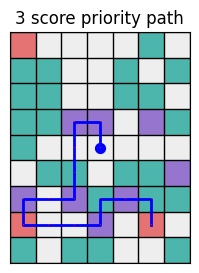

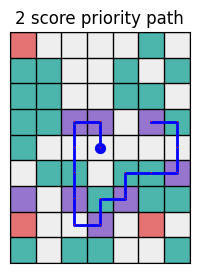

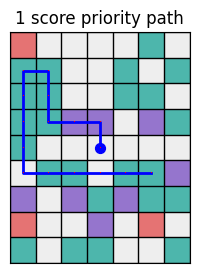

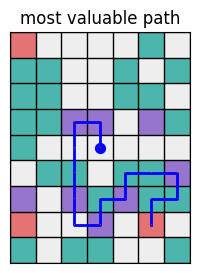

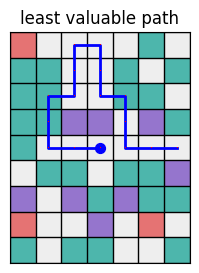

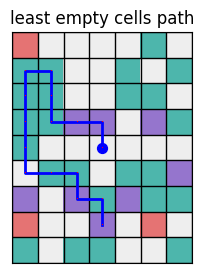

In [7]:
paths_analysis = find_extreme_paths(paths_inf)
visualize_field_with_path(field, paths_analysis['priority_path_3']['path'],'3 score priority path')
visualize_field_with_path(field, paths_analysis['priority_path_2']['path'],'2 score priority path')
visualize_field_with_path(field, paths_analysis['priority_path_1']['path'],'1 score priority path')
visualize_field_with_path(field, paths_analysis['max_points_path']['path'],'most valuable path')
visualize_field_with_path(field, paths_analysis['min_points_path']['path'],'least valuable path')
visualize_field_with_path(field, paths_analysis['min_empty_path']['path'],'least empty cells path')

In [8]:
def analyze_path_usage(paths):
    field_usage = [[0 for _ in range(field_cols)] for __ in range(field_rows)]
    
    for path in paths:
        for coordinate in path['coordinates']:
            row, col = coordinate
            field_usage[row][col] += 1
    
    return field_usage

def visualize_field_usage(field_usage, figsize=(5, 8), interpolation='none'):
    """Visualizes the field usage with overlay of usage counts."""
    cmap = plt.get_cmap('turbo')
    max_usage = np.max(field_usage)
    
    # Normalize the usage values to scale between 0 and the length of the colormap minus one
    normalized_usage = np.array(field_usage) / max_usage
    
    plt.figure(figsize=figsize)
    im = plt.imshow(normalized_usage, cmap=cmap, interpolation=interpolation)
    
    
    plt.grid(which='both', color='black', linestyle='-', linewidth=0.2)
    plt.xticks(np.arange(-0.5, len(field_usage[0]), 1), "")
    plt.yticks(np.arange(-0.5, len(field_usage), 1), "")
    
    # Overlay usage counts
    for i in range(len(field_usage)):
        for j in range(len(field_usage[0])):
            plt.text(j, i, f'{field_usage[i][j]}', ha='center', va='center', color='black')
    
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title('Field Usage Visualization')
    plt.show()

def filter_paths_by_points(paths, points):
    filtered_paths = [path for path in paths if path['sum_of_points'] == points]
    return filtered_paths

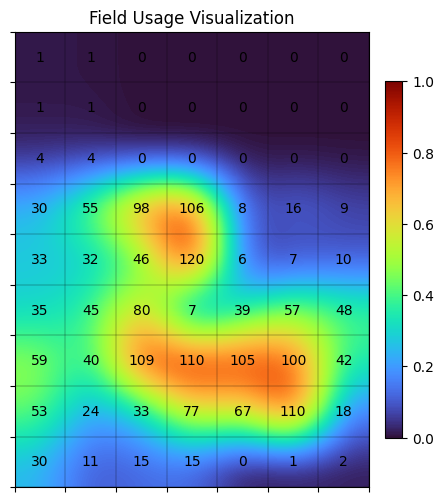

In [9]:
#visualize_field_usage(field_usage)
field_usage = analyze_path_usage(paths_inf)
paths_inf_filtered = filter_paths_by_points(paths_inf, 20)
field_usage_filtered = analyze_path_usage(paths_inf_filtered)
#visualize_field(field)
visualize_field_usage(field_usage_filtered,interpolation='bicubic')

In [10]:
def animate_field_usage_for_points_sums(paths_inf, points_range, figsize=(5, 7)):
    fig, ax = plt.subplots(figsize=figsize)
    cmap = plt.get_cmap('turbo')

    def animate(points):
        ax.clear()
        filtered_paths = filter_paths_by_points(paths_inf, points)
        field_usage_filtered = analyze_path_usage(filtered_paths)
        max_usage = np.max(field_usage_filtered) if np.max(field_usage_filtered) != 0 else 1
        normalized_usage = np.array(field_usage_filtered) / max_usage
        
        im = ax.imshow(normalized_usage, cmap=cmap, interpolation='hermite')
        ax.set_title(f'Field Usage for Paths with {points} Points')

        # Overlay usage counts
#        for i in range(len(field_usage_filtered)):
#            for j in range(len(field_usage_filtered[0])):
#                ax.text(j, i, f'{field_usage_filtered[i][j]}', ha='center', va='center', color='black')
        
        # Remove ticks
        ax.set_xticks([])
        ax.set_yticks([])
        
        fig.tight_layout()

    # Creating animation
    ani = animation.FuncAnimation(fig, animate, frames=points_range, repeat=False)

    plt.close()
    return ani

points_range = range(2, 21)
ani = animate_field_usage_for_points_sums(paths_inf, points_range)

from IPython.display import HTML
HTML(ani.to_jshtml())

In [11]:
def plot_paths_dependency(paths):
    points_count = {}

    for path in paths:
        points = path['sum_of_points']
        if points in points_count:
            points_count[points] += 1
        else:
            points_count[points] = 1

    sorted_points = sorted(points_count.items())

    points, counts = zip(*sorted_points)

    plt.figure(figsize=(10, 5))
    plt.bar(points, counts, color='skyblue')
    plt.title('Dependency of the Amount of Paths on Points Collected')
    plt.xlabel('Points Collected')
    plt.ylabel('Number of Paths')

    plt.xticks(np.arange(min(points), max(points)+1, 1))

    plt.grid(axis='y')
    plt.show()

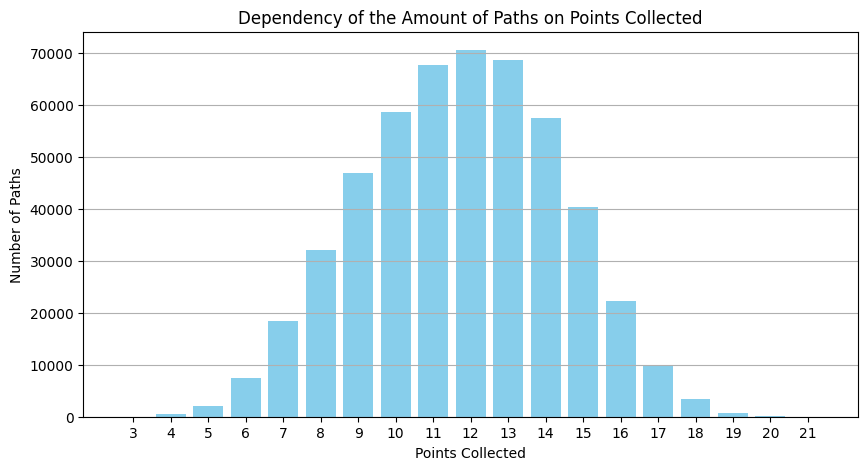

In [12]:
plot_paths_dependency(paths_inf)